# Aimlytics


Import libraries


In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Image Acquisition and Pre-processing
We want to obtain a clear image, ready to be analyzed.

(np.float64(-0.5), np.float64(959.5), np.float64(1279.5), np.float64(-0.5))

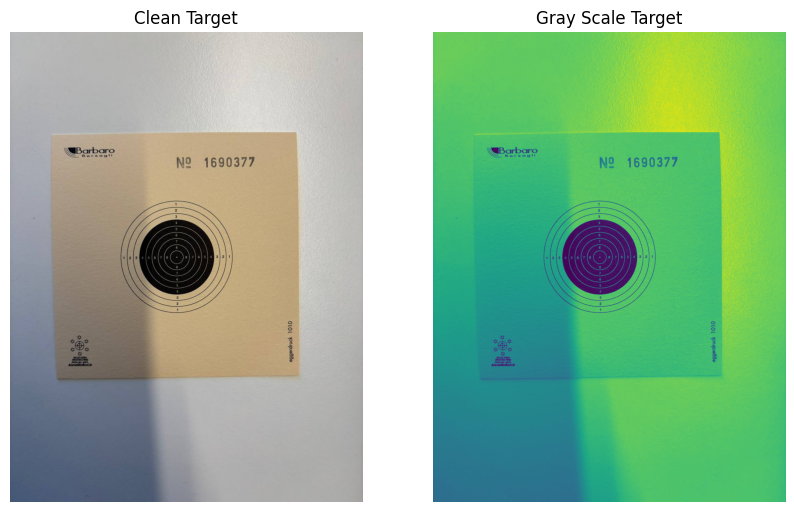

In [23]:
image = cv2.imread("target_images/clean_target.jpg")

plt.figure(figsize=(10, 13), facecolor='white')         #CORREGGEREEEE non fa vedere il background bianco quindi le foto non sono a colori
plt.subplot(121)
plt.title("Clean Target")
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(122)
plt.title("Gray Scale Target")
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2GRAY))
plt.axis('off')

- Correct perspective with warpPerspective() (DINAMICAMENTE solo dopo rilevamento cerchio bersaglio)
- Filter noise with (Gaussian??)
- Smooth out the image to remove noise



(np.float64(-0.5), np.float64(959.5), np.float64(1279.5), np.float64(-0.5))

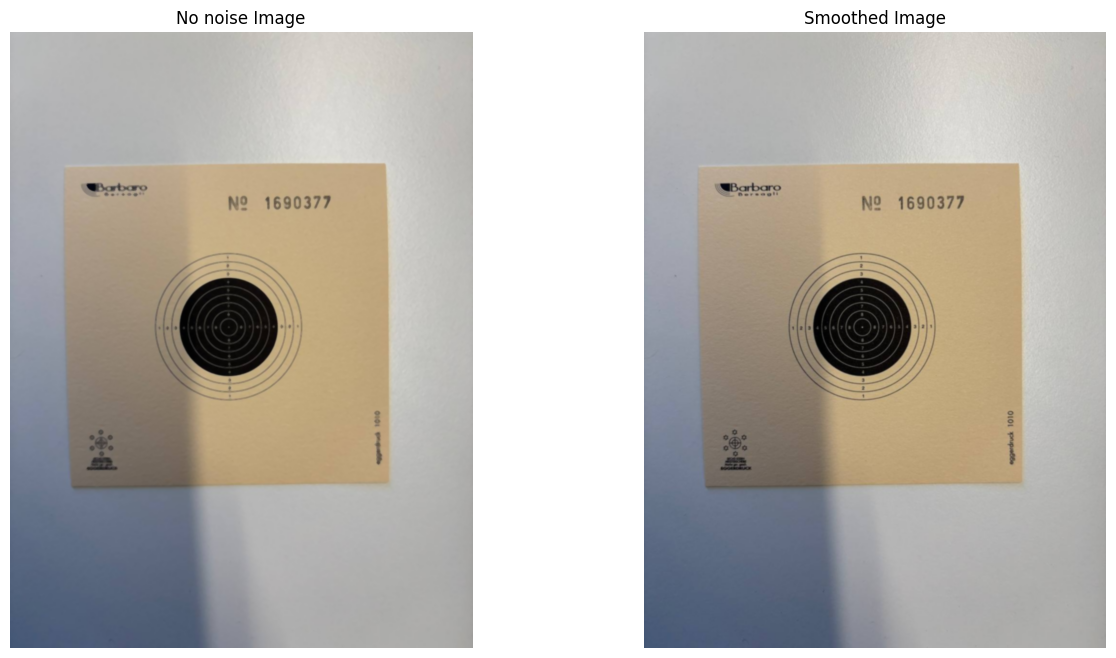

In [6]:
# pts1 = np.float32([[219,209],[612,8],[380,493],[785,271]])
# # Size of the Transformed Image
# pts2 = np.float32([[0,0],[500,0],[0,400],[500,400]])
#
# perspective_matrix = cv2.getPerspectiveTransform(pts1, pts2)
# corrected_perspective_image = cv2.warpPerspective(image, perspective_matrix, image.shape[1::-1])

smoothed_image = cv2.GaussianBlur(image,(5,5),0)
no_noise_image = cv2.medianBlur(smoothed_image,5)


plt.figure(figsize=(15, 8), facecolor='white')
# plt.title("Corrected Perspective")
# plt.imshow(cv2.cvtColor(no_noise_image,cv2.COLOR_BGR2RGB))
# plt.axis('off')
plt.subplot(121)
plt.title("No noise Image")
plt.imshow(cv2.cvtColor(no_noise_image,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(122)
plt.title("Smoothed Image")
plt.imshow(cv2.cvtColor(smoothed_image,cv2.COLOR_BGR2RGB))
plt.axis('off')

## Target Recognition

error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - src is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'src'


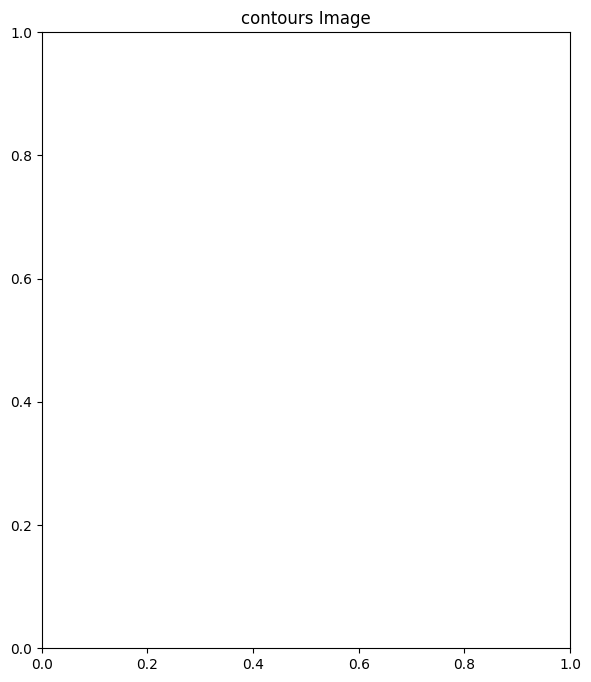

In [21]:
edges = cv2.Canny(smoothed_image,50,150)
contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
#contours_image = cv2.findContours(no_noise_image, cv2.RETR_EXTERNAL, cv2.CV_8UC1)
#poly_target_contour = cv2.approxPolyDP(no_noise_image, 0.01*cv2.arcLength(no_noise_image, True), True)
plt.figure(figsize=(15, 8), facecolor='white')

plt.subplot(121)
plt.title("contours Image")
plt.imshow(cv2.cvtColor(contours,cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(122)
plt.title("poly_target_contour Image")
#plt.imshow(cv2.cvtColor(poly_target_contour,cv2.COLOR_BGR2RGB))
plt.axis('off')